# Week 9 - Multivariate Analysis, part 2

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from google.colab import files
from datetime import datetime, timedelta
import os
from sklearn.preprocessing import LabelEncoder
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("katehighnam/beth-dataset")

filename = 'labelled_training_data.csv'

csv_path = os.path.join(path, filename)

beth = pd.read_csv(csv_path)

pd.set_option('display.max_columns', None)

beth.head()

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
0,1809.495787,381,7337,1,100,4026532231,close,ip-10-100-1-120,157,prctl,"[140662171848350, 11649800180280676]",5,0,"[{'name': 'option', 'type': 'int', 'value': 'P...",1,0
1,1809.495832,381,7337,1,100,4026532231,close,ip-10-100-1-120,3,close,[140662171777451],1,0,"[{'name': 'fd', 'type': 'int', 'value': 19}]",1,0
2,1809.495921,381,7337,1,100,4026532231,close,ip-10-100-1-120,1010,sched_process_exit,[],0,0,[],1,0
3,1894.139651,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,21,access,[],2,-2,"[{'name': 'pathname', 'type': 'const char*', '...",1,0
4,1894.142127,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,1005,security_file_open,"[139778263990104, 139778263906698]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",1,0


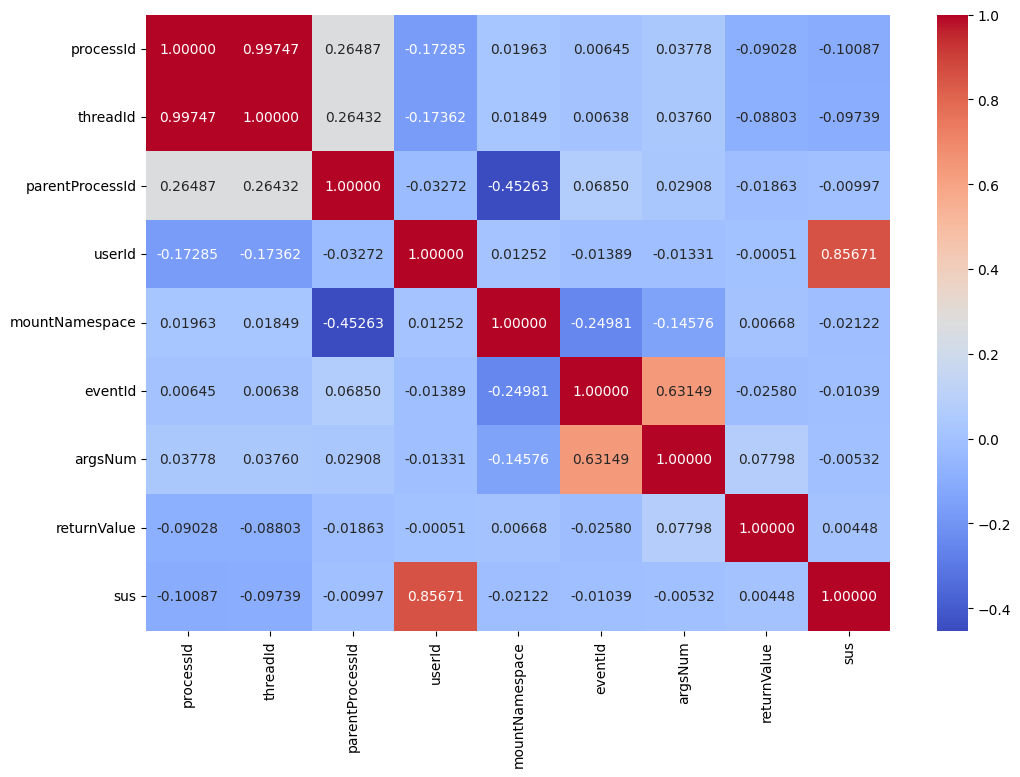

In [10]:
# Possible removal

test = beth[['processId',	'threadId',	'parentProcessId',	'userId',	'mountNamespace',	'eventId',	'argsNum', 'returnValue', 'sus']]

most_cat = test.corr()

plt.figure(figsize=(12,8))
sns.heatmap(most_cat, cmap='coolwarm', annot=True, fmt='.5f')
plt.show()

In [6]:
# Strong pairs of correlation

unstack = most_cat.unstack()
pairs = unstack[unstack.index.get_level_values(0) != unstack.index.get_level_values(1)]
strong_pairs = pairs[abs(pairs) >= 0.4]
strong_pairs = strong_pairs.sort_values(ascending=False).drop_duplicates()
print(strong_pairs)

processId        threadId          0.997469
userId           sus               0.856705
argsNum          eventId           0.631485
parentProcessId  mountNamespace   -0.452629
dtype: float64


<ipython-input-7-6dfc80ce8ec0>:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=bubble_data, x='eventName', y='sus', size='count', sizes=(50, 1000), palette='coolwarm', legend='brief')


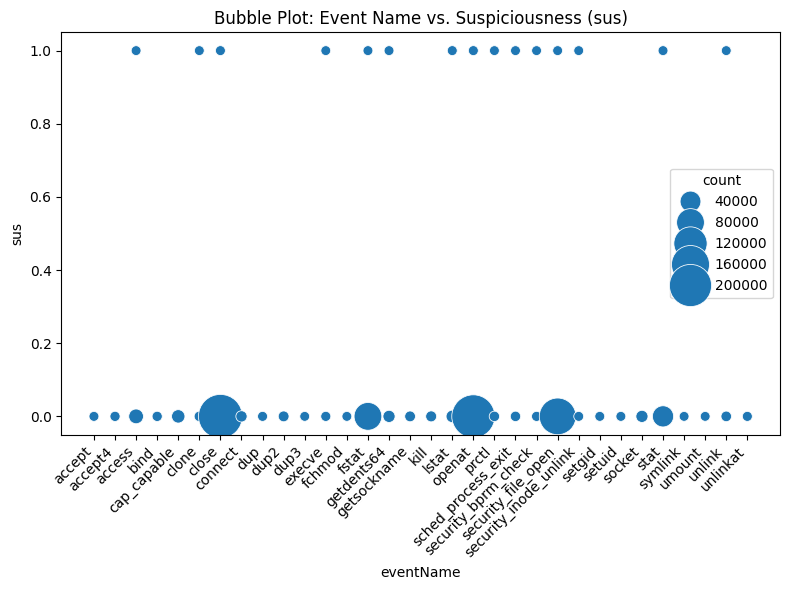

In [7]:
# Bubble Plot of eventName vs. sus

bubble_data = beth.groupby(['eventName', 'sus']).agg(
    count=('eventName', 'size'),
    avg_evil=('evil', 'mean')
).reset_index()

plt.figure(figsize=(8,6))
sns.scatterplot(data=bubble_data, x='eventName', y='sus', size='count', sizes=(50, 1000), palette='coolwarm', legend='brief')

plt.title('Bubble Plot: Event Name vs. Suspiciousness (sus)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The large bubbles for 'close', 'fstat', 'openat', 'security_file_open', and 'stat' indicate high numbers of events. However, it shown that a majority of these events are benign.

The most frequent 'sus' events are shown in the next line of code.

In [11]:
beth[beth['sus'] == 1]['eventName'].value_counts()

,count
eventName,
openat,299
lstat,260
close,223
stat,114
fstat,111
security_file_open,95
getdents64,78
sched_process_exit,34
access,14


In [16]:
beth_encoded = beth.copy()
beth_encoded = beth_encoded.drop(columns=['args'])  # Dropping 'args' because it is unstructured and unnecessary for encoding
beth_encoded['timestamp'] = pd.to_datetime(beth_encoded['timestamp'])
beth_encoded['time_since_start'] = (beth_encoded['timestamp'] - beth_encoded['timestamp'].min()).dt.total_seconds()
beth_encoded = beth_encoded.drop(columns=['timestamp']) # no longer needed

# Next, it is best to frequency encode high-cardinality categorical features (and create new features)
for col in ['processName', 'hostName', 'eventName']:
    beth_encoded[col + '_freq'] = beth_encoded[col].map(beth_encoded[col].value_counts())

# Drop original high-cardinality string columns. These are not ideal for encoding.
beth_encoded = beth_encoded.drop(columns=['processName', 'hostName', 'eventName', 'stackAddresses'])

# Label encode any remaining object columns
label_encode = {}
for col in beth_encoded.select_dtypes(include=['object']).columns:
    LE = LabelEncoder()
    beth_encoded[col] = LE.fit_transform(beth_encoded[col])
    label_encode[col] = LE

# Drop target variables for unsupervised PCA
no_target = beth_encoded.drop(columns=['sus', 'evil'])

# Scale data
scaler = StandardScaler()
beth_encoded_caled = scaler.fit_transform(no_target)

# PCA
pca = PCA(n_components=10)
pca.fit(beth_encoded_caled)


for i, comp in enumerate(pca.components_):
    print(f"PCA Component {i+1}: {comp}")

print("\nExplained Variance Ratios:", pca.explained_variance_ratio_)
print("Total Explained Variance:", sum(pca.explained_variance_ratio_))

PCA Component 1: [ 0.41687281  0.41675569  0.24460435 -0.12199784 -0.3569831   0.21445406
  0.19252576 -0.06258811  0.15049594  0.44631936 -0.33680552  0.1676846 ]
PCA Component 2: [ 0.46256162  0.46189141 -0.06910349 -0.13829301  0.42418223 -0.3230263
 -0.26029794 -0.09001389 -0.17581136  0.03713622  0.38063606  0.10717374]
PCA Component 3: [ 0.03561546  0.03499912 -0.44136124 -0.02297789  0.28847254  0.48839488
  0.55406503  0.06049683 -0.36494676  0.14449795  0.12388382  0.01928683]
PCA Component 4: [ 0.13775819  0.13831861  0.49610783 -0.09106055  0.08917818  0.27862545
  0.28111885  0.13403388  0.27478749 -0.3827834   0.36338191 -0.41330396]
PCA Component 5: [ 0.02230998  0.02460233 -0.10463139 -0.31009151 -0.04116902 -0.16776155
 -0.07482153  0.87954158 -0.06589874  0.1468466  -0.11409907 -0.20937258]
PCA Component 6: [ 0.15664614  0.15641518  0.10135081  0.85460058 -0.03601003 -0.03393183
 -0.04803639  0.18321821 -0.28437211  0.05682224 -0.08647423 -0.28369627]
PCA Component 7: 

The top 5 components explain 74% of the variance in the dataset, which suggests strong underlying structure in the data.

In [19]:
# Logistic Regression

X = beth_encoded.drop(columns=['sus'])
y = beth_encoded['sus']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train with balanced class weights because the frequency of true attacks is much less than normal traffic events.
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy Score: {accuracy}")
print(f"Classification Report:\n{class_report}")

Accuracy Score: 0.9987027367014132
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    152375
           1       0.56      1.00      0.72       254

    accuracy                           1.00    152629
   macro avg       0.78      1.00      0.86    152629
weighted avg       1.00      1.00      1.00    152629



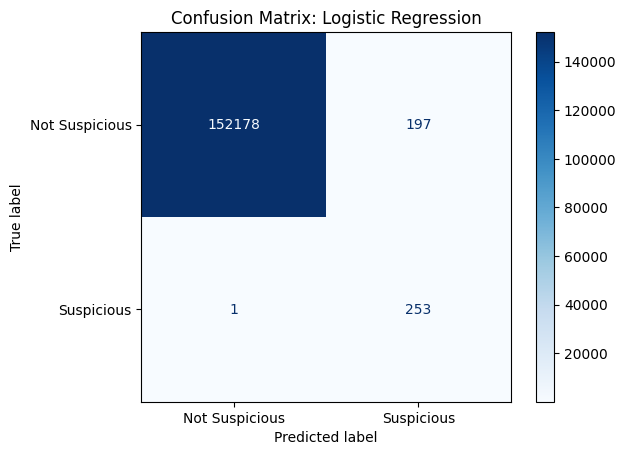

In [23]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Suspicious', 'Suspicious'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

The logistic regression model performed exceptionally well in detecting suspicious activity within this dataset. After handling severe class imbalance using class_weight='balanced', the model achieved an overall accuracy of about 99%. Most importantly, it attained a perfect recall of 1.00 for the minority class (suspicious events), meaning it successfully identified all instances of suspicious activity. This is a critical requirement in cybersecurity where missing a threat can have severe consequences. The precision for the suspicious class was 0.56, indicating that some false positives were flagged, which is an acceptable trade-off in security systems where it’s safer to over-alert than to under-detect. The F1-score for suspicious events reached 0.72, reflecting a strong balance between precision and recall.